In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers
import keras
from keras.callbacks import ModelCheckpoint

In [ ]:
os.chdir('/kaggle/input/electronics-input/')
from helper_functions import join_feature, find_substring,remove_stopwords, extract_nums, replace_string,remove_numbers,extract_namex, replace_first_word,brand_name,replace_from_dict,replace_phone_with_brand_name,age,remove_keywords,keep_first_n_words,join_model_and_modelx, age,ram_memory_nums

train_df= pd.read_csv('Train.csv')
test_df= pd.read_csv('Test.csv')
targets = pd.DataFrame(train_df['Price'])
train_df.drop(['Price'], inplace= True, axis=1)

all_data= pd.concat([train_df,test_df]) #combine train and test data

In [ ]:
all_data.head()

In [ ]:
all_data_cleaned = pd.read_excel('/kaggle/input/cleaned-data/to_modifyX_new.xlsx')

In [ ]:
all_data_cleaned.head()

In [ ]:
all_data=all_data_cleaned.drop(['index', 'Price'], axis=1)

In [ ]:
all_data.head()

In [ ]:
all_data.head()

In [ ]:
# lets see which rows are garbage values (coz garbage in garbage out)
# 1. Rows that do not contain any info about the phone (no info about model, storage, ram etc)
# 2. outliers 

In [ ]:
#add brand_name column
all_data['brand_name']= all_data.apply(lambda x: brand_name(x['Brand']), axis=1)
all_data.drop('Brand', axis=1, inplace=True)
all_data['Model_Info']= all_data.apply(lambda x: replace_from_dict(x['Model_Info']), axis=1)
all_data['Additional_Description']= all_data.apply(lambda x: replace_from_dict(x['Additional_Description']), axis=1)
all_data['Model_Info']= all_data.apply(lambda x: replace_phone_with_brand_name(x['Model_Info'], x['brand_name']), axis=1)
all_data['Additional_Description']= all_data.apply(lambda x: replace_phone_with_brand_name(x['Additional_Description'],x['brand_name']), axis=1)
all_data['Model_Info']= all_data.apply(lambda x: replace_first_word(x['Model_Info'], x['brand_name']), axis=1)
all_data['Additional_Description']= all_data.apply(lambda x: replace_first_word(x['Additional_Description'],x['brand_name']), axis=1)

all_data['age']= all_data.apply(lambda x: age(x['Model_Info'],x['Additional_Description']), axis=1)


In [ ]:
ram_keywords = ['2gb','3gb','6gb','4gb', '8gb', '12gb', '2 gb','3 gb','6 gb','4 gb', '8 gb', '12 gb']
memory_keywords = ['16gb','32gb','64gb','128gb', '256gb', '16 gb','32 gb','64 gb','128 gb', '256 gb', '32', '64', '128', '256']
list_of_iphones= ['iphone 3g', 'iphone 3 g','iphone 3gs','iphone 3 g s','iphone 4', 'iphone 4s', 'iphone 4 s','iphone 5', 'iphone 5s', 'iphone 5 s', 'iphone 6', 'iphone 6plus','iphone 6 plus','iphone 6s', 'iphone 6 s','iphone 7','iphone 7 plus', 'iphone 7plus','iphone 8','iphone 8 plus','iphone 8plus','iphone x','iphone xr','iphone xs','iphone x s','iphone xs max','iphone x s max','iphone xr','iphone x r', 'iphone 11', 'iphone 11 pro', 'iphone 11pro', 'iphone 11 pro max', 'iphone 11pro max', 'iphone 11promax', 'iphone se', 'iphone s e'] 
list_of_bat=['1000 mah','1000mah','2000mah','2000 mah','3000 mah','3000mah','4000 mah', '4000mah', '5000 mah','5000mah','6000 mah', '6000mah', '3100 mah', '3100mah','3200 mah','3200mah', '4100 mah','4100mah']


In [ ]:
all_data['ram_memory_nums'] = all_data.apply(lambda x: ram_memory_nums(x['Model_Info']), axis=1)
all_data ['ram_mod'] = all_data.apply(lambda x: find_substring(x['Model_Info'], ram_keywords), axis=1)
all_data ['ram_add'] = all_data.apply(lambda x: find_substring(x['Additional_Description'], ram_keywords), axis=1)
all_data ['ram_nums'] = all_data.apply(lambda x: find_substring(x['ram_memory_nums'], ram_keywords), axis=1)

all_data ['memory_mod'] = all_data.apply(lambda x: find_substring(x['Model_Info'], memory_keywords), axis=1)
all_data ['memory_add'] = all_data.apply(lambda x: find_substring(x['Additional_Description'], memory_keywords), axis=1)
all_data ['memory_nums'] = all_data.apply(lambda x: find_substring(x['ram_memory_nums'], memory_keywords), axis=1)

In [ ]:
all_data ['model_mod'] = all_data.apply(lambda x: find_substring(x['Model_Info'], list_of_iphones), axis=1) 
all_data ['model_add'] = all_data.apply(lambda x: find_substring(x['Additional_Description'], list_of_iphones), axis=1)


In [ ]:
all_data ['ram'] = all_data.apply(lambda x: join_feature(x['ram_mod'], x['ram_add'], x['ram_nums']), axis=1)

all_data ['memory'] = all_data.apply(lambda x: join_feature(x['memory_mod'], x['memory_add'], x['memory_nums']), axis=1)

all_data ['model'] = all_data.apply(lambda x: join_feature(x['model_mod'], x['model_add'], []), axis=1)

In [ ]:
all_data['ram'] = all_data.apply(lambda x: replace_string(x['ram'],'gb', ''), axis=1)
all_data['memory'] = all_data.apply(lambda x: replace_string(x['memory'],'gb', ''), axis=1)

# drop garbage columns
all_data=all_data[['brand_name', 'Model_Info', 'Additional_Description', 'ram', 'memory','model', 'age','State']]


In [ ]:
all_data ['modelx'] = all_data.apply(lambda x: keep_first_n_words(x['Model_Info'], 3), axis=1)
all_data['modelx'] = all_data.apply(lambda x: remove_keywords(x['modelx'], ram_keywords+memory_keywords), axis=1)
all_data['model'] = all_data.apply(lambda x: join_model_and_modelx(x['model'], x['modelx']), axis=1)
all_data.drop(['modelx'], inplace=True, axis=1)



In [ ]:
# get the name of models occuring 5 times atleast

In [ ]:
no_ram=all_data[all_data['ram']=='None']

In [ ]:
no_ram_mem =  no_ram[no_ram['memory']=='None']

In [ ]:
all_data

In [ ]:
# handling rare values
group = all_data.groupby('model')
group.filter(lambda x: len(x) >= 100) 

all_data.loc[all_data['model'].value_counts()[all_data['model']].values < 3, 'model'] = "RARE_VALUE"

In [ ]:
all_data['model'].value_counts()
# Suggesstions
# 1. remove 'iphone' keyword from strings in model column, replace name414 by xs, name229 by max, then assign rare values again

In [ ]:
all_data_cleaned.shape

In [ ]:
all_data_cleaned_g_dropped =all_data_cleaned[all_data_cleaned['model'] != 'g']

In [ ]:
all_data_cleaned_g_dropped.head()

In [ ]:
train_labels= pd.DataFrame(all_data_cleaned_g_dropped.head(2253)['Price'])

In [ ]:
train_labels[train_labels['Price']>80000] = 80000 

In [ ]:
#check for outliers
train_labels.describe()

In [ ]:
all_data=all_data_cleaned_g_dropped.drop(['index', 'Price', 'Model_Info','Additional_Description'], axis=1)


In [ ]:
all_data.head()

In [ ]:
data_to_encode= all_data

# encoding categorical data
data_to_encode=data_to_encode.astype(str)
data_to_encode = pd.get_dummies(data_to_encode).reset_index(drop=True)
data_to_encode=pd.DataFrame(data_to_encode)

In [ ]:
data_to_encode.head()

In [ ]:
data_to_encode.shape

In [ ]:
train_labels.shape

In [ ]:
targets=train_labels.to_numpy()
#traindata=data_to_encode.head(2326)
traindata=data_to_encode.head(2253)


testdata=data_to_encode.tail(997)
X=traindata
X_test=testdata

traindata=traindata.to_numpy()
testdata=testdata.to_numpy()

In [ ]:
testdata

In [ ]:
numFeatures=traindata.shape[0]
batch_size=1
no_epochs=100
verbosity=1
validation_split=0.2
loss_per_fold = []
inputs= traindata

In [ ]:
def build_model():
    #with strategy.scope():
    model =tf.keras.Sequential([
        tf.keras.layers.Dense(numFeatures,activation='relu'),
         tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256,activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear'),
        ])

    msle = tf.keras.losses.MeanSquaredLogarithmicError()

    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss=msle, optimizer=optimizer)

    return model

In [ ]:
model_path='/kaggle/working/'
os.chdir(model_path)
VER='v0'; DISPLAY=0

In [ ]:
#train on whole data without folds
sv = keras.callbacks.ModelCheckpoint(
       'whole_data_cleaned.h5', monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto')
model = build_model()
print('------------------------------------------------------------------------')
    
history=model.fit(inputs,targets,batch_size=batch_size, epochs=no_epochs,verbose=DISPLAY,validation_split=validation_split, callbacks=[sv])
    



In [ ]:
model.load_weights('whole_data_cleaned.h5')

In [ ]:
#predictions
#predictions =model.predict(testdata)
#pred_df = pd.DataFrame(predictions)



In [ ]:
#pred_df.max()

In [ ]:
#pred_df.columns=['Price']
#pred_df.to_excel('val_loss_0.27307_model_5fea.xlsx', engine='xlsxwriter', index=False)  

In [ ]:
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000



In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

In [ ]:
#setup multiple models
#Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=2000,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)



In [ ]:
stack_gen = StackingCVRegressor(regressors=(xgboost,lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
scores = {} #13143.2923 (1007.2599) 13289.2002 (425.5238) for 4 splits

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

#splits =5 10541.9396 (794.7138)

In [ ]:
score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())
#splits =5 9474.8692 (831.8462)

In [ ]:
score = cv_rmse(svr)#22274.4238 (1653.1884)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

#splits 5- 20725.5077 (1060.5680)

In [ ]:
# Support Vector Regressor
svr2 = make_pipeline(RobustScaler(), SVR(C= 50, epsilon= 0.008, gamma=0.005))
score = cv_rmse(svr2)
print("SVR2: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr2'] = (score.mean(), score.std())



In [ ]:
score = cv_rmse(ridge) #ridge: 12305.3566 (1151.9819)
print("ridge: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['ridge'] = (score.mean(), score.std())
#splits - 5 ridge: 9153.6941 (707.5234)

In [ ]:
score = cv_rmse(rf) #13014 for 1200 estimators
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())
#splits - 5 9922.1984 (738.1172)

In [ ]:
score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())
#splits - 5 - 10283.7857 (1130.5510)

In [ ]:
score = cv_rmse(stack_gen)
print("stack_gen_model: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['stack_gen_model'] = (score.mean(), score.std())
#splits - 4 

In [ ]:
print("stack_gen_model: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(X), np.array(train_labels))

In [91]:
print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, train_labels)

lightgbm


In [92]:
print('xgboost')
xgb_model_full_data = xgboost.fit(X, train_labels)

xgboost
[16:37:25] WARNING: /workspace/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [93]:
print('Svr')
svr_model_full_data = svr.fit(X, train_labels)

Svr


In [94]:
print('Ridge')
ridge_model_full_data = ridge.fit(X, train_labels)

Ridge


In [95]:
print('RandomForest')
rf_model_full_data = rf.fit(X, train_labels)

RandomForest


In [96]:
print('GradientBoosting')
gbr_model_full_data = gbr.fit(X, train_labels)

GradientBoosting


In [ ]:
#os.chdir('/kaggle/working/')
#model.load_weights('whole_data_model_5_features.h5')

In [141]:
a=0.1
b=0.0
c=0.025
d= 0.1
e=0.025
f= 0.5
g = 0.25
print(a+b+c+d+e+f+g)
print('a : {}\nb : {}\nc : {}\nd : {}\ne : {}\nf : {}\ng : {}'.format(a,b,c,d,e,f,g))

1.0
a : 0.1
b : 0.0
c : 0.025
d : 0.1
e : 0.025
f : 0.5
g : 0.25


In [ ]:
#a=0.05, b=0.15, c=0.05, d= 0.1, e=0.05, f= 0.25, g = 0.35 --> RMSLE= 10323.9
#a=0.15, b=0.05, c=0.05, d= 0.1, e=0.05, f= 0.25, g = 0.35 --> RMSLE= 9588
#a=0.15, b=0.00, c=0.05, d= 0.1, e=0.05, f= 0.35, g = 0.30 --> RMSLE= 9205
#a=0.15, b=0.00, c=0.05, d= 0.1, e=0.05, f= 0.4, g = 0.25 --> RMSLE= 9099.7
#a=0.15, b=0.00, c=0.05, d= 0.1, e=0.05, f= 0.5, g = 0.15 --> RMSLE= 8951
# order of priority 
# stackgen > my_model > ridge > xgb > rf> gbr >svr
#f>g>a>d>e>c>b

#for cleaned blended model
#a=0.15, b=0.00, c=0.05, d= 0.15, e=0.15, f= 0.5, g = 0.1 --> RMSLE= 78xx
#a=0.15, b=0.00, c=0.05, d= 0.1, e=0.05, f= 0.5, g = 0.15 --> RMSLE= 7231
#a=0.1, b=0.00, c=0.025, d= 0.1, e=0.025, f= 0.5, g = 0.25 --> RMSLE= 7179


In [133]:
# Blend models in order to make the final predictions more robust to overfitting
def blended_predictions(X):
    
    return ((a* ridge_model_full_data.predict(X)).reshape(-1) + \
            (b * svr_model_full_data.predict(X)) + \
            (c * gbr_model_full_data.predict(X)) + \
            (d * xgb_model_full_data.predict(X)) + \
            (e * rf_model_full_data.predict(X)) + \
            (f * stack_gen_model.predict(np.array(X)))+\
            (g*model.predict(X.to_numpy()).reshape(-1)))

In [142]:
# Get final precitions from the blended model
blended_score = rmsle(train_labels, blended_predictions(X))
#blended_score = rmsle(train_labels, stack_gen_model.predict(np.array(X)))# rmsle of stackgen = 9332.52

#blended_score = rmsle(train_labels, model.predict(X.to_numpy()).reshape(-1)) #rmsle of my NN model = 11541
scores['blended'] = (blended_score, 0)
print('RMSLE score on train data:')
print(blended_score)

RMSLE score on train data:
7179.298583957746


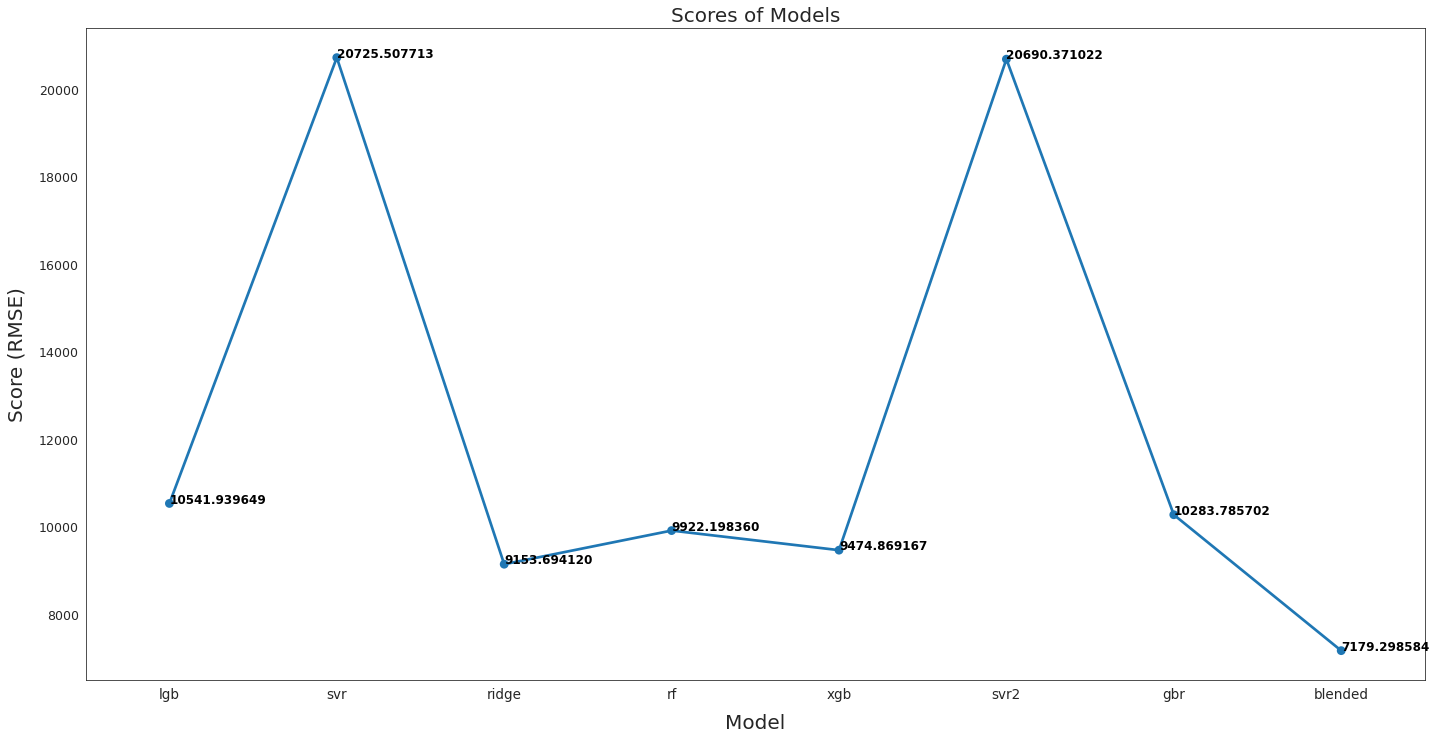

In [143]:
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['-'])
for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [144]:
preds=blended_predictions(X_test)


In [145]:
preds=pd.DataFrame(preds)
preds.head()

,0
0,14416.767826
1,16840.495103
2,15358.790843
3,43728.837284
4,10159.441156


In [147]:
preds.columns=['Price']
preds.to_excel('blended_model_cleaned1.xlsx', engine='xlsxwriter', index=False)  

In [153]:
preds1=pd.DataFrame(model.predict(X_test))
preds1.columns=['Price']
preds1.to_excel('NN_cleaned1.xlsx', engine='xlsxwriter', index=False)  

In [149]:
preds1=pd.DataFrame(preds1)

In [150]:
preds1.head()

,0
0,15381.691406
1,16035.746094
2,16818.738281
3,42638.183594
4,10575.416992


In [151]:
preds.head()

,Price
0,14416.767826
1,16840.495103
2,15358.790843
3,43728.837284
4,10159.441156


In [ ]:
#lets try to train a model seperately for iphone and androids